<a href="https://colab.research.google.com/github/ddlcz/mit-datasci-program/blob/main/SVHN_Digit_Recognition_DaraDelaCruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = ('/content/drive/MyDrive/SVHN_single_grey1.h5')

## **Importing the necessary libraries**

In [ ]:
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import zipfile

import cv2
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow

**Let us check the version of tensorflow.**

In [ ]:
print(tf.__version__)

2.15.0


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [ ]:
h5f = h5py.File(path, 'r')

In [ ]:
#split data in train and test
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

#close the file
h5f.close()

Check the number of images in the training and the testing dataset.

In [ ]:
X_train.shape

(42000, 32, 32)

In [ ]:
X_test.shape

(18000, 32, 32)

**Observation:**


*  There are 42,000 images in the training data set
*  There are 18,000 images in the test data set



## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

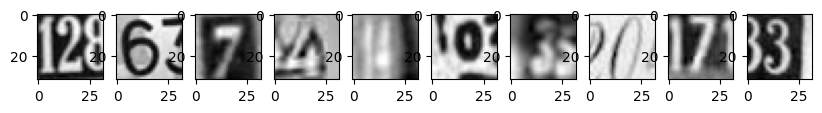

image labels for first 10 images: [2 6 7 4 4 0 3 0 7 3]


In [ ]:
#For loop to visualize first 10 images and labels in the training dataset

plt.figure(figsize=(10,1))

for i in range(10):
  plt.subplot (1,10,i+1)
  plt.imshow(X_train[i], cmap='gray')

plt.show()
print('image labels for first 10 images: %s' % (y_train[0:10]))


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [ ]:
#print shape and array of pixels for 1st image in training dataset

print("Shape:", X_train[0].shape)
print("Array of pixels:\n", X_train[0])

Shape: (32, 32)
Array of pixels:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [ ]:
#Reshape dataset into 1D array
X_train = X_train.reshape(X_train.shape[0], 1024)

X_test = X_test.reshape(X_test.shape[0], 1024)

In [ ]:
#normalize test and training data
X_train = X_train/255.0
X_test = X_test/255.0

Print the shapes of Training and Test data

In [ ]:
#print shapes of training and test data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (42000, 1024)
Shape of X_test: (18000, 1024)


### **One-hot encode output**

In [ ]:
#one-hot encoding for y labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
#ensure number of labels match the number of images
y_test.shape, X_test.shape

((18000, 10), (18000, 1024))

**Observation:**


*   Labels for test and training sets have been converted from original integers to one-hot encoded vectors


## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [ ]:
import random

In [ ]:
#seed() used to initialize random number generator
seed = 42
random.seed()
np.random.seed(seed)
tf.random.set_seed(seed)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [ ]:
def nn_model_1():
  model = Sequential()
  #First hidden layer
  model.add(Dense(64, activation='relu', input_shape=(1024,)))
  #Second hidden layer
  model.add(Dense(32, activation='relu'))
  #Output layer
  model.add(Dense(10, activation='softmax'))
  #Compile model
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

In [ ]:
model_1 = nn_model_1()
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                65600     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 68010 (265.66 KB)
Trainable params: 68010 (265.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Fit on the train data with a validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20
history_model_1 = model_1.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
263/263 [==============================] - 4s 5ms/step - loss: 2.2966 - accuracy: 0.1244 - val_loss: 2.2704 - val_accuracy: 0.1451
Epoch 2/20
263/263 [==============================] - 1s 4ms/step - loss: 2.0783 - accuracy: 0.2590 - val_loss: 1.8438 - val_accuracy: 0.3577
Epoch 3/20
263/263 [==============================] - 2s 6ms/step - loss: 1.6638 - accuracy: 0.4462 - val_loss: 1.5453 - val_accuracy: 0.4933
Epoch 4/20
263/263 [==============================] - 2s 6ms/step - loss: 1.4952 - accuracy: 0.5065 - val_loss: 1.4708 - val_accuracy: 0.5140
Epoch 5/20
263/263 [==============================] - 1s 4ms/step - loss: 1.4063 - accuracy: 0.5422 - val_loss: 1.3800 - val_accuracy: 0.5412
Epoch 6/20
263/263 [==============================] - 1s 4ms/step - loss: 1.3358 - accuracy: 0.5718 - val_loss: 1.3174 - val_accuracy: 0.5781
Epoch 7/20
263/263 [==============================] - 1s 4ms/step - loss: 1.2928 - accuracy: 0.5900 - val_loss: 1.2702 - val_accuracy: 0.6020
Epoch 

### **Plot the Training and Validation Accuracies and write down your Observations.**

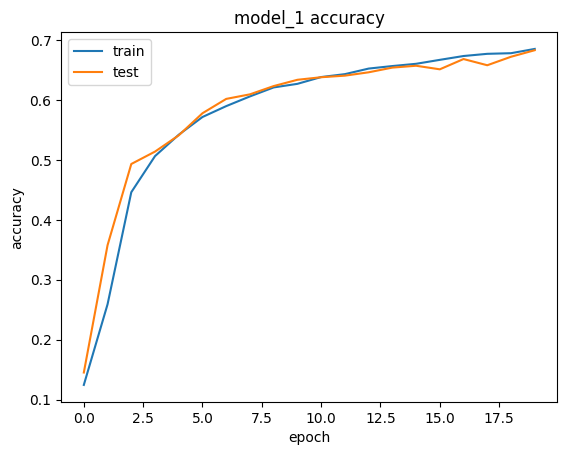

In [ ]:
#Plot accuracy of model 1
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observations:**


* Model 1 resulted in 68,010 total trainable parameters, with accuracy of just under ~68% on the test and train data  
* The training data continued to improve as epochs increased
* Test data accuracy continued to imrpove up until the 16th epoch with slight decreases through the 20th epoch



Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
#reset random seed
seed = 42
random.seed()
np.random.seed(seed)
tf.random.set_seed(seed)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [ ]:
def nn_model_2():
  model = Sequential()
  #First layer
  model.add(Dense(256, activation='relu', input_shape=(1024,)))
  #Second layer
  model.add(Dense(128, activation = 'relu'))
  #Dropout layer = 0.2
  model.add(Dropout(0.2))
  #third layer
  model.add(Dense(64, activation = 'relu'))
  #fourth layer
  model.add(Dense(64, activation = 'relu'))
  #fifth layer
  model.add(Dense(32, activation = 'relu'))
  #BatchNormalization layer
  model.add(BatchNormalization())
  #Output layer with 'softmax'
  model.add(Dense(10, activation = 'softmax'))
  #Compile the model with the loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
  return model

In [ ]:
#build model 2 and print summary
model_2 = nn_model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                1

In [ ]:
#Fit model 2
history_model_2 = model_2.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
263/263 [==============================] - 7s 10ms/step - loss: 2.3465 - accuracy: 0.1049 - val_loss: 2.3094 - val_accuracy: 0.1106
Epoch 2/30
263/263 [==============================] - 2s 8ms/step - loss: 2.2447 - accuracy: 0.1436 - val_loss: 2.1904 - val_accuracy: 0.1696
Epoch 3/30
263/263 [==============================] - 2s 7ms/step - loss: 1.8832 - accuracy: 0.3104 - val_loss: 1.7028 - val_accuracy: 0.4279
Epoch 4/30
263/263 [==============================] - 2s 8ms/step - loss: 1.4901 - accuracy: 0.5002 - val_loss: 1.3862 - val_accuracy: 0.5423
Epoch 5/30
263/263 [==============================] - 2s 8ms/step - loss: 1.3126 - accuracy: 0.5706 - val_loss: 1.1702 - val_accuracy: 0.6296
Epoch 6/30
263/263 [==============================] - 2s 7ms/step - loss: 1.1947 - accuracy: 0.6152 - val_loss: 1.0897 - val_accuracy: 0.6538
Epoch 7/30
263/263 [==============================] - 2s 6ms/step - loss: 1.1338 - accuracy: 0.6372 - val_loss: 1.0956 - val_accuracy: 0.6518
Epoch

### **Plot the Training and Validation Accuracies and write down your Observations.**

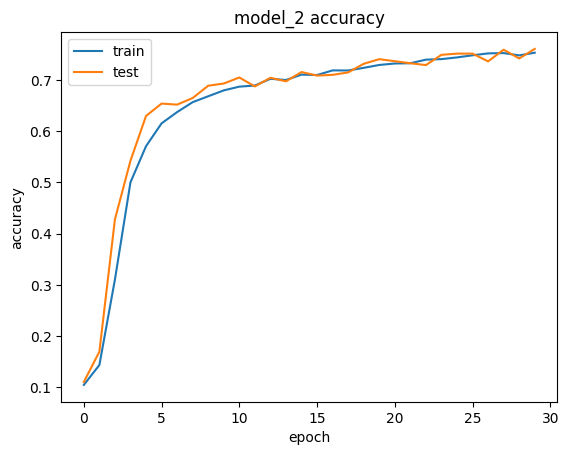

In [ ]:
#Plot accuracy of model 2
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('model_2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observations:**


*   Model 2 has an increased nuber of 310,000 total trainable parameters, and had an increased accuracy of ~75% (compared to the 68% accuracy in model 1)
* The addition of regularization such as a dropout layer and Batch Normalization reduced overfitting, and resulted in a higher performance compared to the previous model, which did not have any regularization
*   The test validation accuracy surpassed the training accuracy from the first 11 epochs, indicating that this model will perform well on new and unseen data



## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [ ]:
#Make predictions on the test data using model_2
pred = model_2.predict(X_test)
pred = np.argmax(pred, axis=-1)

563/563 [==============================] - 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [ ]:
#convert y_test to a single label from one-hot encoded vector
y_test = np.argmax(y_test, axis=-1)

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

In [ ]:
#import libraries for classiication report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
#print classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1814
           1       0.71      0.81      0.76      1828
           2       0.83      0.75      0.79      1803
           3       0.72      0.71      0.72      1719
           4       0.70      0.85      0.77      1812
           5       0.76      0.72      0.74      1768
           6       0.85      0.69      0.76      1832
           7       0.80      0.79      0.79      1808
           8       0.71      0.73      0.72      1812
           9       0.74      0.74      0.74      1804

    accuracy                           0.76     18000
   macro avg       0.76      0.76      0.76     18000
weighted avg       0.76      0.76      0.76     18000



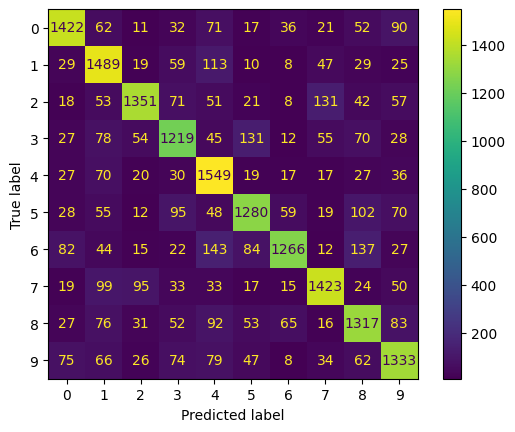

In [ ]:
#display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

**Final Observations:**


*   Recall: is high overall across all labels, lowest recall on label 6 at 69%, where the label is mostly being mistaken for 4s or 8s
*   Precision: Also fairly high of at least 71% across all labels, with label 6 having highest precision
* Label 6 had highest precision, and lowest recall resulting in accurate identification of this label, but missed many true positives.
* Label 4 is the inverse, where it had the highest recall, but lower precision, in which many of the true positives are identified, but included many false positives.




## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [ ]:
#load dataset
h5f = h5py.File(path, 'r')

In [ ]:
#split data in train and test
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

#close the file
h5f.close()

Check the number of images in the training and the testing dataset.

In [ ]:
X_train.shape, X_test.shape

((42000, 32, 32), (18000, 32, 32))

**Observation:**


*   There are 42,000 images in the training dataset
*   And 18,000 images in the test dataset




## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [ ]:
#print shape of pixels for the first image
print("first image shape:\n",
      X_train[0].shape)

first image shape:
 (32, 32)


In [ ]:
#print array of pixels for first image
print("first image array:\n",
      X_train[0])

first image array:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [ ]:
#Reshape test and train dataset as 4D arrays
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [ ]:
#Normalize training and test inputs
X_train = X_train/255.0
X_test = X_test/255.0

Print New shape of Training and Test

In [ ]:
#print new shape of test and train data
print("new shape of training inputs:", X_train.shape)
print("shape of training labels:", y_train.shape)
print("new shape of testing dataset:", X_test.shape)
print("shape of testing labels:", y_test.shape)

new shape of training inputs: (42000, 32, 32, 1)
shape of training labels: (42000,)
new shape of testing dataset: (18000, 32, 32, 1)
shape of testing labels: (18000,)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [ ]:
#one-hot encode labels in training and test sets
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape, X_train.shape

((42000, 10), (42000, 32, 32, 1))

**Observation:**


*   The test and train data have been reshaped to 4D arrays for the convolutional neural network, displaying the same amount of pixels 32 x 32, and 1 channel in the images representing that the images are monochrome

*  On the training data, the number of inputs, match the number of labels 42,000

* Labels have been converted again from integers to one-hot encoded vectors


## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [ ]:
#seed() used to initialize random number generator
import random

seed = 42
random.seed()
np.random.seed(seed)
tf.random.set_seed(seed)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [ ]:
def cnn_model_1():
  model = Sequential()
  #First convuloutional layer
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 1)))
  #LeakyRelu slope 0.1
  model.add(LeakyReLU(alpha=0.1))
  #Second convolutional layer
  model.add(Conv2D(32, (3, 3), padding='same'))
  #LeakyRelu slope 0.1
  model.add(LeakyReLU(alpha=0.1))
  #max-pooling layer with 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #flatten output from prev layer
  model.add(Flatten())
  #dense layer with 32 nodes
  model.add(Dense(32))
  #LeakyRelu slope 0.1
  model.add(LeakyReLU(alpha=0.1))
  #final layer with 10 nodes, and  softmax activation
  model.add(Dense(10, activation = 'softmax'))
  #compile model
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

In [ ]:
#build cnn model 1 and print summary
cnn_model_1 = cnn_model_1()
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

In [ ]:
#fit cnn model 1
history_cnn_model_1 = cnn_model_1.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
1050/1050 [==============================] - 11s 6ms/step - loss: 1.1188 - accuracy: 0.6334 - val_loss: 0.6402 - val_accuracy: 0.8120
Epoch 2/20
1050/1050 [==============================] - 9s 8ms/step - loss: 0.5313 - accuracy: 0.8464 - val_loss: 0.5283 - val_accuracy: 0.8536
Epoch 3/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.4420 - accuracy: 0.8720 - val_loss: 0.5005 - val_accuracy: 0.8570
Epoch 4/20
1050/1050 [==============================] - 6s 6ms/step - loss: 0.3882 - accuracy: 0.8875 - val_loss: 0.4543 - val_accuracy: 0.8735
Epoch 5/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.3430 - accuracy: 0.8983 - val_loss: 0.4978 - val_accuracy: 0.8625
Epoch 6/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.3054 - accuracy: 0.9098 - val_loss: 0.4616 - val_accuracy: 0.8710
Epoch 7/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.2737 - accuracy: 0.9189 - val_loss: 0.4762 - val_accuracy

### **Plot the Training and Validation Accuracies and Write your observations.**

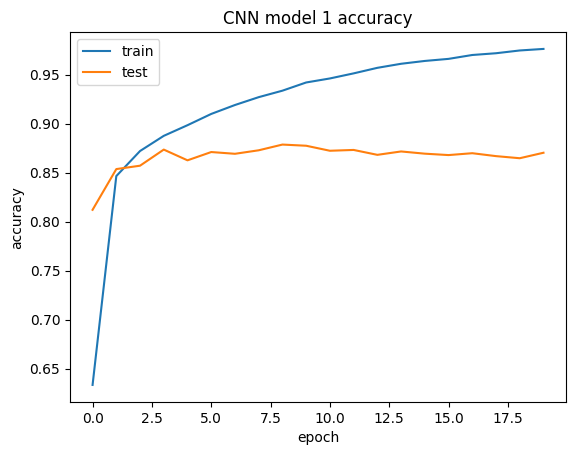

In [ ]:
#plot accuracy data for CNN Model 1
plt.plot(history_cnn_model_1.history['accuracy'])
plt.plot(history_cnn_model_1.history['val_accuracy'])
plt.title('CNN model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observations:**


*   CNN Model 1 performed very well with over 97% accuracy on the training data, but idid not perform significantly as well on testing data at 86%, suggesting that overfitting is occuring
* CNN Model 1 had 2 convolutional layers and used the LeakyRelu activation method. It resulted in 267,306 total traininable parameters
*   The training data increased with each epoch, though the test set remained consistent at ~86% accuracy with each epoch
* this suggests that CNN Model 1 will not perform as accurately as the training data with new and unseen data introduced to the model


Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [ ]:
#clear backend and reset seed
backend.clear_session()

In [ ]:
#reset random seed
seed = 42
random.seed()
np.random.seed(seed)
tf.random.set_seed(seed)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [ ]:
def cnn_model_2():
  model = Sequential()

  #First convuloutional layer
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 1)))
  #LeakyRelu layer with slope 0.1
  model.add(LeakyReLU(alpha=0.1))
  #Second convolutional layer
  model.add(Conv2D(32, (3, 3), padding='same'))
  #LeakyRelu layer
  model.add(LeakyReLU(alpha=0.1))
  #maxpooling layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  #BatchNormalization Layer
  model.add(BatchNormalization())
  #Third Convolutional layer
  model.add(Conv2D(32, (3, 3), padding='same'))
  #LeakyRelu layer
  model.add(LeakyReLU(alpha=0.1))
  #Fourth Convolutional Layer
  model.add(Conv2D(64, (3, 3), padding='same'))
  #LeakyRelu layer
  model.add(LeakyReLU(alpha=0.1))
  #maxpooling layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  #BatchNormalization Layer
  model.add(BatchNormalization())
  #flatten output
  model.add(Flatten())
  #Dense Layer
  model.add(Dense(32))
  #LeakyRelu layer
  model.add(LeakyReLU(alpha=0.1))
  #Dropout layer
  model.add(Dropout(0.5))
  #Output layer
  model.add(Dense(10, activation='softmax'))
  #compile model
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model


In [ ]:
#build cnn model 2 and print summary
cnn_model_2 = cnn_model_2()
cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                         

In [ ]:
#fit cnn model 2
history_cnn_model_2 = cnn_model_2.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.2, verbose=1,)

Epoch 1/30
263/263 [==============================] - 12s 9ms/step - loss: 1.4856 - accuracy: 0.4903 - val_loss: 1.4996 - val_accuracy: 0.4489
Epoch 2/30
263/263 [==============================] - 2s 6ms/step - loss: 0.6805 - accuracy: 0.7913 - val_loss: 0.5641 - val_accuracy: 0.8318
Epoch 3/30
263/263 [==============================] - 2s 7ms/step - loss: 0.5546 - accuracy: 0.8310 - val_loss: 0.4333 - val_accuracy: 0.8735
Epoch 4/30
263/263 [==============================] - 2s 7ms/step - loss: 0.4836 - accuracy: 0.8542 - val_loss: 0.4674 - val_accuracy: 0.8645
Epoch 5/30
263/263 [==============================] - 2s 7ms/step - loss: 0.4429 - accuracy: 0.8655 - val_loss: 0.4073 - val_accuracy: 0.8843
Epoch 6/30
263/263 [==============================] - 2s 8ms/step - loss: 0.4097 - accuracy: 0.8741 - val_loss: 0.4122 - val_accuracy: 0.8864
Epoch 7/30
263/263 [==============================] - 3s 10ms/step - loss: 0.3792 - accuracy: 0.8830 - val_loss: 0.4273 - val_accuracy: 0.8810
Epoc

### **Plot the Training and Validation accuracies and write your observations.**

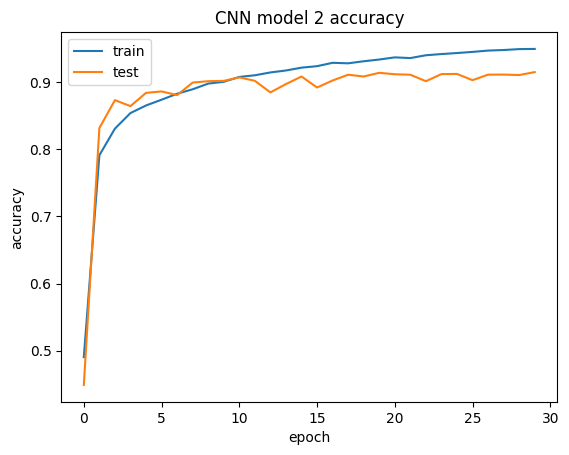

In [ ]:
#plot accuracy data for CNN Model 2
plt.plot(history_cnn_model_2.history['accuracy'])
plt.plot(history_cnn_model_2.history['val_accuracy'])
plt.title('CNN model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Observations:**



*   CNN model 2 continued to use the LeakyRelu activation function, but also included 4 convultional layers, and regularization including batch normalization and dropout.
* CNN Model 2 resulted in 164,362 trainable parameters, which is slightly more than half the number of trainable parameters in CNN Model 1.
*   Validation accuracy reached 90% after 8 epochs and remained around 90% accuracy throughout the process.
* Training and validation accuracy are much similar to each other with training accurary ~94% and validation ~90%, suggesting that this model has eliminated much of the overfitting in CNN Model 1.
* CNN Model 2 is expected to perform better than CNN Model 1 on new and unseen data.




## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [ ]:
#prediction on test data with CNN model 2
pred = cnn_model_2.predict(X_test)
pred = np.argmax(pred, axis=-1)

563/563 [==============================] - 3s 4ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [ ]:
#convert y_test from one-hot encoded to single labels
y_test = np.argmax(y_test, axis=-1)

### **Write your final observations on the performance of the model on the test data.**

In [ ]:
#import library for confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#print classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1814
           1       0.92      0.91      0.92      1828
           2       0.92      0.93      0.93      1803
           3       0.91      0.89      0.90      1719
           4       0.94      0.92      0.93      1812
           5       0.93      0.90      0.91      1768
           6       0.90      0.91      0.90      1832
           7       0.93      0.94      0.94      1808
           8       0.89      0.92      0.91      1812
           9       0.91      0.90      0.90      1804

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000



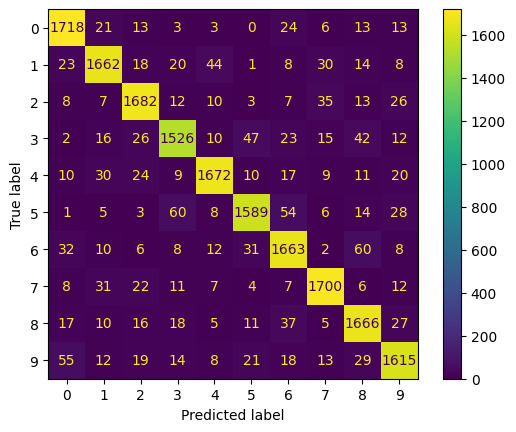

In [ ]:
#plot confusion  matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

**Final Observations:**

* CNN Model 2 performed better than NN Model 2 in detecting accurate predictions across all labels. In general, the number of predicted labels vs. true labels is higher, ilustrating that CNN Model 2 had a higher accuracy rate.

* Precision and recall have increased significantly with all labels having at least 89% precision and recall, resulting in high F1 scores.

* Reviewing the results of all models, convolutional neural networks with additional layers and added regularization resulted in the most accurate predictions across the 4 models created.

In [ ]:
%%shell
jupyter nbconvert --to html /content/High_Code_SVHN_Digit_Recognition_DaraDelaCruz.ipynb

[NbConvertApp] Converting notebook /content/High_Code_SVHN_Digit_Recognition_DaraDelaCruz.ipynb to html
[NbConvertApp] Writing 1081821 bytes to /content/High_Code_SVHN_Digit_Recognition_DaraDelaCruz.html
